In [1]:
import sys
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.abspath("../src/"))

In [3]:
from EmbVector import Vector

## **CNN Model**
## Getting datas
**best_sim mode** : The "Sum" colum of datas is the sum of vector Variation and all `top_number` vectors most similar to Variation without the vector of other existing variation for the gene

> **Formula**
>
> Sum = vect_Variation + sum(most_similar(`top_number`)) - sum(vect_other_variation_for_gene) 

In [ ]:
datas = Vector(data_file = "../datas/training_clean", 
        model_path = "../datas/cbow_A3316_WS20_E20_B10000_R2000_CTrue.model", 
        is_training = True)
# type_sum values : gene_var, best_sim, clean_art, sim_gene_var
# top_number only use with best_sim or sim_gene_var, defautl = 50
datas.get_vector_datas(is_notebook = True, type_sum =  "best_sim")

________________________Getting datas vectors_______________________
____________________________________________________________________
Number of genes/variations not foud : 688
____________________________________________________________________
Getting vectors finished in 87.24612657100005 seconds


In [5]:
X = datas.vectors[['Gene','Variation','Sum']]

Y = pd.get_dummies(datas.vectors["Class"]).values

In [6]:
print(X['Gene'].shape)
print(X['Variation'].shape)
print(X['Sum'].shape)

(3314,)
(3314,)
(3314,)


## CNN all datas in one input
First we need to split datas to reshape  and clean the shape

In [7]:
X_gene = X["Gene"]
X_var = X["Variation"]
X_sum = X["Sum"]

In [8]:
X_gene = X_gene.values.reshape(X_gene.shape[0], 1)
X_var = X_var.values.reshape(X_var.shape[0], 1)
X_sum = X_sum.values.reshape(X_sum.shape[0], 1)

In [9]:
def convert_to_np_gene(Object):
    np_list = []
    for obj in Object:
        cop = obj[0].copy()
        np_list.append(np.array(cop))
    return np.array(np_list)

def convert_to_np_var_sum(Object):
    np_list = []
    for obj in Object:
        for o in obj:
            cop = o[0].copy()
            np_list.append(np.array(cop))
    return np.array(np_list)

In [10]:
X_gene = convert_to_np_gene(X_gene)
X_var = convert_to_np_var_sum(X_var)
X_sum = convert_to_np_var_sum(X_sum)

In [11]:
print("X_gene : " + str(X_gene.shape))
print("X_var : " + str(X_var.shape))
print("X_sum : " + str(X_sum.shape))

print("Y : " + str(Y.shape))

X_gene : (3314, 100)
X_var : (3314, 100)
X_sum : (3314, 100)
Y : (3314, 9)


In [12]:
X_gene = X_gene.reshape(X_gene.shape[0],X_gene.shape[1], 1)
X_var = X_var.reshape(X_var.shape[0], X_var.shape[1], 1)
X_sum = X_sum.reshape(X_sum.shape[0], X_sum.shape[1], 1)

In [13]:
print("X_gene : " + str(X_gene.shape))
print("X_var : " + str(X_var.shape))
print("X_sum : " + str(X_sum.shape))

print("Y : " + str(Y.shape))

X_gene : (3314, 100, 1)
X_var : (3314, 100, 1)
X_sum : (3314, 100, 1)
Y : (3314, 9)


## Reform the X_train with cleaned shape

In [14]:
X_concat = np.concatenate((X_gene, X_var, X_sum), axis = 1) 

In [15]:
X_concat.shape

(3314, 300, 1)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_concat, Y, test_size = 0.2, random_state = 42, stratify=Y)
print("X_train : " + str(X_train.shape))
print("Y_train : " + str(Y_train.shape))
print("X_test : " + str(X_test.shape))
print("Y_test : " + str(Y_test.shape))

X_train : (2651, 300, 1)
Y_train : (2651, 9)
X_test : (663, 300, 1)
Y_test : (663, 9)


## Building the model

In [17]:
cnn_model = Sequential()
cnn_model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
cnn_model.add(layers.Conv1D(32, kernel_size=(3), activation='relu'))
cnn_model.add(layers.Conv1D(64, kernel_size=(3), activation='relu'))
cnn_model.add(layers.GlobalMaxPooling1D())
cnn_model.add(layers.Dense(10, activation='relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(9, activation='softmax'))
cnn_model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
cnn_model.summary() 

2021-10-23 16:18:09.939835: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-23 16:18:09.939994: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-23 16:18:09.940676: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 298, 32)           128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 64)           6208      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
_________________________________________________________________
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 99        
Total params: 7,085
Trainable params: 7,085
Non-trainable params: 0
______________________________________________________

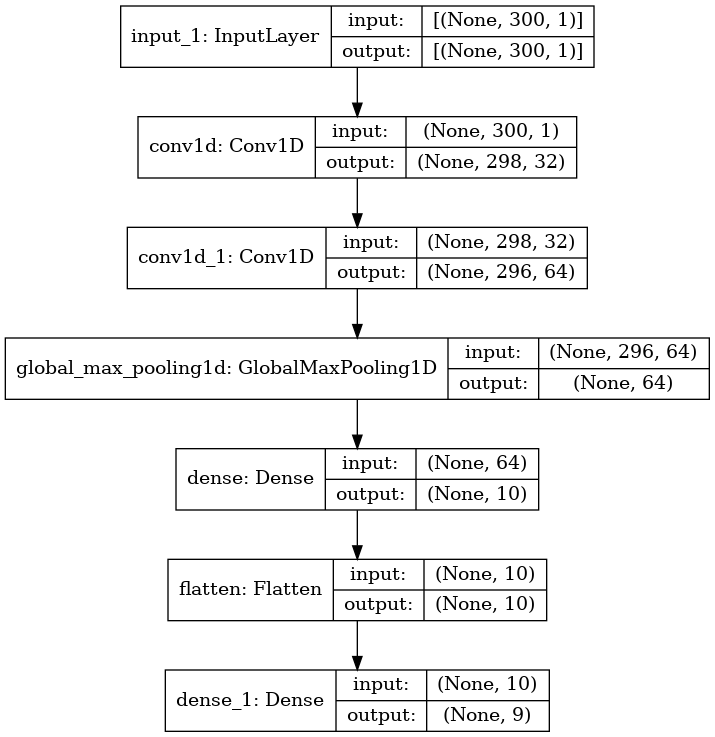

In [18]:
keras.utils.plot_model(cnn_model, "CNN_W2V_bs.png", show_shapes= True)

In [19]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = cnn_model.fit(X_train, Y_train,
                     epochs=50,
                     verbose=False,
                     validation_split = 0.2,
                     batch_size= 32, 
                     callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
)

2021-10-23 16:18:23.070524: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-23 16:18:23.073584: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2803195000 Hz


In [21]:
loss, accuracy = cnn_model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: %.3f %%"  % (accuracy * 100.0))

Training Accuracy: >54.017


In [24]:
loss, accuracy = cnn_model.evaluate(X_test, Y_test, verbose=False)

print("Testing Accuracy:  %.3f %%"  % (accuracy * 100.0))

Testing Accuracy:  >52.338


In [ ]:
cnn_model.save("../results/CNN_W2V_bs.model") 

2021-10-23 14:23:01.847534: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../results/CNN_W2V_Separate_datas_gv_68_8.model/assets
